<a href="https://colab.research.google.com/github/Miyamura80/BotsForGames/blob/main/BotsForGames_Sprint2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# environment:
!pip3 install torch
!pip install --upgrade open_spiel

     |████████████████████████████████| 4.4 MB 13.0 MB/s 
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# Implementation of hex board state


In [90]:
import numpy as np
import pyspiel
import copy

BOARD_SIZE = 4
game = pyspiel.load_game("hex",{"board_size":BOARD_SIZE})
BLACK, WHITE = 1, -1  # first turn or second turn player

class State:
    '''Board implementation of BOARD_SIZE x BOARD_SIZE Hex Board'''
    X, Y = 'ABCDEFGHI'[0:BOARD_SIZE],  '123456789'[0:BOARD_SIZE]
    C = {0: '_', BLACK: 'O', WHITE: 'X'}

    def __init__(self):
        self.board = np.zeros((BOARD_SIZE, BOARD_SIZE)) # (x, y)
        self.color = 1
        self.win_color = 0
        self.record = []
        self.hex_state = game.new_initial_state()

    def action2str(self, a: int):
        return self.X[a // BOARD_SIZE] + self.Y[a % BOARD_SIZE]

    def str2action(self, s: str):
        return self.X.find(s[0]) * BOARD_SIZE + self.Y.find(s[1])

    def record_string(self):
        return ' '.join([self.action2str(a) for a in self.record])
    
    def __deepcopy__(self):
        newState = State()
        newState.board = copy.deepcopy(self.board)
        newState.win_color = copy.deepcopy(self.win_color)
        newState.record = copy.deepcopy(self.record)
        newState.hex_state = copy.deepcopy(self.hex_state)
        return newState

    def __str__(self):
        final_bd = [" "+" ".join(self.Y)]
        hex_bd = str(self.hex_state).split("\n")
        for i in range(len(hex_bd)):
            final_bd.append(self.X[i]+" "+hex_bd[i])
        return "\n".join(final_bd)

    def play(self, action):
        # state transition function
        # action is position interger (0~8) or string representation of action sequence
        # Handles the case where action is sequence of actions "0 1 2 3 4"
        if isinstance(action, str):
            for astr in action.split():
                self.play(self.str2action(astr))
            return self

        # Single action case
        x, y = action // BOARD_SIZE, action % BOARD_SIZE
        self.board[x, y] = self.color
        self.hex_state.apply_action(action)

        # check whether 3 stones are on the line
        if self.hex_state.is_terminal():
            self.win_color = self.color

        self.color = -self.color
        self.record.append(action)
        return self

    def terminal(self):
        # terminal state check
        return self.hex_state.is_terminal()

    def terminal_reward(self):
        # terminal reward 
        # return self.win_color if self.color == BLACK else -self.win_color
        return self.win_color

    def legal_actions(self):
        # list of legal actions on each state
        return [a for a in range(BOARD_SIZE * BOARD_SIZE) if self.board[a // BOARD_SIZE, a % BOARD_SIZE] == 0]

    def feature(self):
        # input tensor for neural net (state)
        # return np.stack([self.board == self.color, self.board == -self.color]).astype(np.float32)
        observation =  np.array(self.hex_state.observation_tensor(), np.float32)
        return observation.reshape(9,BOARD_SIZE,BOARD_SIZE)

    def action_feature(self, action):
        # input tensor for neural net (action)
        a = np.zeros((1, BOARD_SIZE, BOARD_SIZE), dtype=np.float32)
        a[0, action // BOARD_SIZE, action % BOARD_SIZE] = 1
        return a

# Small neural nets with PyTorch

In [4]:
# Small neural nets with PyTorch

import torch
import torch.nn as nn
import torch.nn.functional as F


print(torch.cuda.is_available())

# convnet from input channels w number filters0, output channels w number filters1
class Conv(nn.Module):
    def __init__(self, filters0, filters1, kernel_size, bn=False):
        super().__init__()
        self.conv = nn.Conv2d(filters0, filters1, kernel_size, stride=1, padding=kernel_size//2, bias=False)
        self.bn = None
        if bn:
            self.bn = nn.BatchNorm2d(filters1)

    def forward(self, x):
        h = self.conv(x)
        if self.bn is not None:
            h = self.bn(h)
        return h

# 3x3 conv filter with same input & output channels 
class ResidualBlock(nn.Module):
    def __init__(self, filters):
        super().__init__()
        self.conv = Conv(filters, filters, 3, True)

    def forward(self, x):
        return F.relu(x + (self.conv(x)))

True


# Networks

In [5]:
num_filters = 16
num_blocks = 4

class Representation(nn.Module):
    ''' Conversion from observation to inner abstract state '''
    def __init__(self, input_shape):
        super().__init__()
        self.input_shape = input_shape
        self.board_size = self.input_shape[1] * self.input_shape[2]

        self.layer0 = Conv(self.input_shape[0], num_filters, BOARD_SIZE, bn=True)
        
        self.blocks = nn.ModuleList([ResidualBlock(num_filters) for _ in range(num_blocks)])

    def forward(self, x):
        h = F.relu(self.layer0(x))
        for block in self.blocks:
            h = block(h)
        return h

    def inference(self, x):
        self.eval()
        with torch.no_grad():
            rp = self(torch.from_numpy(x).unsqueeze(0).to('cuda'))
        return rp.cpu().numpy()[0]

class Prediction(nn.Module):
    ''' Policy and value prediction from inner abstract state '''
    def __init__(self, action_shape):
        super().__init__()
        self.board_size = np.prod(action_shape[1:])
        self.action_size = action_shape[0] * self.board_size

        self.conv_p1 = Conv(num_filters, 4, 1, bn=True)
        self.conv_p2 = Conv(4, 1, 1)

        self.conv_v = Conv(num_filters, 4, 1, bn=True)
        self.fc_v = nn.Linear(self.board_size * 4, 1, bias=False)

    def forward(self, rp):
        h_p = F.relu(self.conv_p1(rp))
        h_p = self.conv_p2(h_p).view(-1, self.action_size)

        h_v = F.relu(self.conv_v(rp))
        h_v = self.fc_v(h_v.view(-1, self.board_size * 4))

        # range of value is -1 ~ 1
        return F.softmax(h_p, dim=-1), torch.tanh(h_v)

    def inference(self, rp):
        self.eval()
        with torch.no_grad():
            p, v = self(torch.from_numpy(rp).unsqueeze(0).to('cuda'))
        return p.cpu().numpy()[0], v.cpu().numpy()[0][0]

class Dynamics(nn.Module):
    '''Abstract state transition'''
    def __init__(self, rp_shape, act_shape):
        super().__init__()
        self.rp_shape = rp_shape
        self.layer0 = Conv(rp_shape[0] + act_shape[0], num_filters, 3, bn=True)
        self.blocks = nn.ModuleList([ResidualBlock(num_filters) for _ in range(num_blocks)])

    def forward(self, rp, a):
        h = torch.cat([rp, a], dim=1)
        h = self.layer0(h)
        for block in self.blocks:
            h = block(h)
        return h

    def inference(self, rp, a):
        self.eval()
        with torch.no_grad():
            rp = self(torch.from_numpy(rp).unsqueeze(0).to('cuda'), torch.from_numpy(a).unsqueeze(0).to('cuda'))
        return rp.cpu().numpy()[0]

''' Collects all h, f, g functions in one net, and predict outcome ''' 
class Net(nn.Module):
    '''Whole net'''
    def __init__(self):
        super().__init__()
        state = State()
        input_shape = state.feature().shape
        print(input_shape)
        action_shape = state.action_feature(0).shape
        rp_shape = (num_filters, *input_shape[1:])

        self.representation = Representation(input_shape)
        self.prediction = Prediction(action_shape)
        self.dynamics = Dynamics(rp_shape, action_shape)

    def predict(self, state0, path):
        '''
        Predict p and v from original state and path
        Return [(p1,v1), (p2,v2), ...]
        Where path :: [Action]
        '''
        
        outputs = []
        x = state0.feature()
        rp = self.representation.inference(x)
        outputs.append(self.prediction.inference(rp))
        for action in path:
            a = state0.action_feature(action)
            rp = self.dynamics.inference(rp, a)
            outputs.append(self.prediction.inference(rp))
        return outputs

In [6]:
def show_net(net, state):
    '''Display policy (p) and value (v)'''
    print(state)
    p, v = net.predict(state, [])[-1]
    print('p = ')
    print((p * 1000).astype(int).reshape((-1, *net.representation.input_shape[1:3])))
    print('v = ', v)
    print()

#  Outputs before training
show_net(Net().to('cuda'), State())

(9, 5, 5)
 1 2 3 4 5
A . . . . . 
B  . . . . . 
C   . . . . . 
D    . . . . . 
E     . . . . . 
p = 
[[[38 39 39 41 41]
  [39 40 39 41 40]
  [39 40 38 40 40]
  [40 41 38 39 39]
  [40 41 39 39 37]]]
v =  0.005403269



# Heatmap

In [7]:
import matplotlib.pyplot as plt

def display_heatmap2(grid):
  fig, ax = plt.subplots()
  im = ax.imshow(grid)
  # Loop over data dimensions and create text annotations.
  for i in range(grid.shape[0]):
      for j in range(grid.shape[1]):
          text = ax.text(j, i, round(grid[i, j],2),
                        ha="center", va="center", color="w")
  plt.show()

def display_heatmap(A):
  X, Y = np.meshgrid(range(A.shape[0]), range(A.shape[-1]))
  X, Y = X*2, Y*2
  
  # Turn this into a hexagonal grid
  for i, k in enumerate(X):
      if i % 2 == 1:
          X[i] += 1
          Y[:,i] += 1

  fig, ax = plt.subplots()
  im = ax.hexbin(
      X.reshape(-1), 
      Y.reshape(-1), 
      C=A.reshape(-1), 
      gridsize=int(A.shape[0]/2)
  )

  # the rest of the code is adjustable for best output
  ax.set_aspect(0.8)
  ax.set(xlim=(-4, X.max()+4,), ylim=(-4, Y.max()+4))
  ax.axis(False)
  plt.colorbar(im)
  plt.show()


# MuZero Monte Carlo Tree Search


In [8]:
# Implementation of Monte Carlo Tree Search

class Node:
    '''Search result of one abstract (or root) state'''
    def __init__(self, p, v):#
        ''' Policy and Value '''
        self.p, self.v = p, v
        self.n, self.q_sum = np.zeros_like(p), np.zeros_like(p)
        self.n_all, self.q_sum_all = 1, v / 2 # prior

    def update(self, action, q_new):
        # Update
        self.n[action] += 1
        self.q_sum[action] += q_new

        # Update overall stats
        self.n_all += 1
        self.q_sum_all += q_new

In [30]:
import time
import copy

class Tree:
    '''Monte Carlo Tree'''
    def __init__(self, net):
        self.net = net
        self.nodes = {}

    def search(self, state, path, rp, depth):
        # Return predicted value from new state
        key = state.record_string()
        if len(path) > 0:
            key += '|' + ' '.join(map(state.action2str, path))
        if key not in self.nodes:
            p, v = self.net.prediction.inference(rp)
            self.nodes[key] = Node(p, v)
            return v

        # State transition by an action selected from bandit
        node = self.nodes[key]
        p = node.p
        mask = np.zeros_like(p)
        if depth == 0:
            # Add noise to policy on the root node
            p = 0.75 * p + 0.25 * np.random.dirichlet([0.15] * len(p))
            # On the root node, we choose action only from legal actions
            mask[state.legal_actions()] = 1
            p *= mask
            p /= p.sum() + 1e-16

        n, q_sum = 1 + node.n, node.q_sum_all / node.n_all + node.q_sum
        ucb = q_sum / n + 2.0 * np.sqrt(node.n_all) * p / n + mask * 4 # PUCB formula
        best_action = np.argmax(ucb)

        # Search next state by recursively calling this function
        rp_next = self.net.dynamics.inference(rp, state.action_feature(best_action))
        path.append(best_action)
        q_new = -self.search(state, path, rp_next, depth + 1) # With the assumption of changing player by turn
        node.update(best_action, q_new)

        return q_new

    def think(self, state, num_simulations, temperature = 0, show=False):
        # End point of MCTS
        if show:
            print(state)
        start, prev_time = time.time(), 0
        for _ in range(num_simulations):
            self.search(state, [], self.net.representation.inference(state.feature()), depth=0)

            # Display search result on every second
            if show:
                tmp_time = time.time() - start
                if int(tmp_time) > int(prev_time):
                    prev_time = tmp_time
                    root, pv = self.nodes[state.record_string()], self.pv(state)
                    n = root.n + 1
                    n = (n / np.max(n)) ** (1 / (temperature + 1e-8))
                    disp_grid = (n / n.sum()).reshape(BOARD_SIZE, BOARD_SIZE)
                    display_heatmap2(disp_grid)
                    print('%.2f sec. best %s. q = %.4f. n = %d / %d. pv = %s'
                          % (tmp_time, state.action2str(pv[0]), root.q_sum[pv[0]] / root.n[pv[0]],
                             root.n[pv[0]], root.n_all, ' '.join([state.action2str(a) for a in pv])))

        #  Return probability distribution weighted by the number of simulations
        root = self.nodes[state.record_string()]
        n = root.n + 1
        n = (n / np.max(n)) ** (1 / (temperature + 1e-8))
        return n / n.sum()

    def pv(self, state):
        # Return principal variation (action sequence which is considered as the best)
        s, pv_seq = state.__deepcopy__(), []
        while True:
            key = s.record_string()
            if key not in self.nodes or self.nodes[key].n.sum() == 0:
                break
            best_action = sorted([(a, self.nodes[key].n[a]) for a in s.legal_actions()], key=lambda x: -x[1])[0][0]
            pv_seq.append(best_action)
            s.play(best_action)
        return pv_seq
    
    def values(self, state):
        s, pv_seq = copy.deepcopy(state), []
        key = s.record_string()
        if key not in self.nodes:
            return np.zeros(BOARD_SIZE*BOARD_SIZE).reshape((BOARD_SIZE,BOARD_SIZE))

        result = np.zeros(BOARD_SIZE*BOARD_SIZE)
        best_actions = [(a, self.nodes[key].n[a]) for a in s.legal_actions()]
        for (a, v) in best_actions:
            result[a] = v
        return result.reshape((BOARD_SIZE,BOARD_SIZE))


In [10]:
# Search with initialized net

tree = Tree(Net().to('cuda'))

tree.think(State(), 100, show=True)
tree.values(State())

# tree = Tree(Net().to('cuda'))
# tree.think(State().play('A1 C1 A2 C2'), 200, show=True)

# tree = Tree(Net().to('cuda'))
# tree.think(State().play('B2 A2 A3 C1 B3'), 200, show=True)

# tree = Tree(Net().to('cuda'))
# tree.think(State().play('B2 A2 A3 C1'), 200, show=True)

(9, 5, 5)
 1 2 3 4 5
A . . . . . 
B  . . . . . 
C   . . . . . 
D    . . . . . 
E     . . . . . 


array([[4., 5., 3., 3., 4.],
       [3., 3., 3., 4., 3.],
       [3., 5., 4., 3., 4.],
       [4., 4., 5., 5., 4.],
       [4., 5., 5., 5., 4.]])

# Training of neural net


In [11]:
# Training of neural net

import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
final_ploss = []
final_vloss = []

batch_size = 32
num_steps = 100

def gen_target(ep, k):
    '''Generate inputs and targets for training'''
    # path, reward, observation, action, policy
    turn_idx = np.random.randint(len(ep[0]))
    ps, vs, ax = [], [], []
    for t in range(turn_idx, turn_idx + k + 1):
        if t < len(ep[0]):
            p = ep[4][t]
            a = ep[3][t]
        else: # state after finishing game
            # p is 0 (loss is 0)
            p = np.zeros_like(ep[4][-1])
            # random action selection
            a = np.zeros(np.prod(ep[3][-1].shape), dtype=np.float32)
            a[np.random.randint(len(a))] = 1
            a = a.reshape(ep[3][-1].shape)
        vs.append([ep[1] if t % 2 == 0 else -ep[1]])
        ps.append(p)
        ax.append(a)
        
    return ep[2][turn_idx], ax, ps, vs

def train(episodes, net, opt):
    '''Train neural net'''
    p_loss_sum, v_loss_sum = 0, 0
    net.train()
    k = 4
    for _ in range(num_steps):
        x, ax, p_target, v_target = zip(*[gen_target(episodes[np.random.randint(len(episodes))], k) for j in range(batch_size)])
        x = torch.from_numpy(np.array(x)).to('cuda')
        ax = torch.from_numpy(np.array(ax)).to('cuda')
        p_target = torch.from_numpy(np.array(p_target)).to('cuda')
        v_target = torch.FloatTensor(np.array(v_target)).to('cuda')

        # Change the order of axis as [time step, batch, ...]
        ax = torch.transpose(ax, 0, 1)
        p_target = torch.transpose(p_target, 0, 1)
        v_target = torch.transpose(v_target, 0, 1)

        # Compute losses for k (+ current) steps
        p_loss, v_loss = 0, 0
        for t in range(k + 1):
            rp = net.representation(x) if t == 0 else net.dynamics(rp, ax[t - 1])
            p, v = net.prediction(rp)
            p_loss += F.kl_div(torch.log(p), p_target[t], reduction='sum')
            v_loss += torch.sum(((v_target[t] - v) ** 2) / 2)

        p_loss_sum += p_loss.item()
        v_loss_sum += v_loss.item()

        optimizer.zero_grad()
        total_loss = Variable(p_loss+v_loss, requires_grad=True)
        total_loss.backward()
        optimizer.step()

    num_train_datum = num_steps * batch_size
    global final_ploss, final_vloss 
    final_ploss.append(p_loss_sum / num_train_datum)
    final_vloss.append(v_loss_sum / num_train_datum)
    print('p_loss %f v_loss %f' % (p_loss_sum / num_train_datum, v_loss_sum / num_train_datum))
    return net

#  Battle against random agents


In [12]:
#  Battle against random agents

def vs_random(net, n=100):
    results = {}
    for i in range(n):
        first_turn = i % 2 == 0
        turn = first_turn
        state = State()
        while not state.terminal():
            if turn:
                p, _ = net.predict(state, [])[-1]
                action = sorted([(a, p[a]) for a in state.legal_actions()], key=lambda x:-x[1])[0][0]
            else:
                action = np.random.choice(state.legal_actions())
            state.play(action)
            turn = not turn
        r = state.terminal_reward() if turn else -state.terminal_reward()
        results[r] = results.get(r, 0) + 1
    return results

# MCTS Agent

In [87]:
from typing import List
import random
import time
from math import sqrt, log
from collections import defaultdict

random.seed(1)
class MCTSAgent:
    def __init__(self) -> None:
        self.best = []
        # Both of these :: path -> dict[move, x]
        self.moves = defaultdict(lambda: defaultdict(int))
        self.reward = defaultdict(lambda: defaultdict(float))
    
    def ucb_weight_general(self, state, mv, epoch, c=2.0):
        path = state.record_string()
        expected_reward = self.reward[path][mv]/(self.moves[path][mv]+1)
        n_visit = self.moves[path][mv]
        return expected_reward + c * sqrt(log(epoch)/(n_visit+1))

    def think(self, state: State, sim_num: int, temperature:int, show=False) -> None:
        if show:
            print("Bot to play: \n", state, state.color)

        start, prev_time = time.time(), 0        
        if state.terminal():
            return
        bot_color = state.color
        init_path = state.record_string()

        for epoch in range(1, sim_num):
            freshState = state.__deepcopy__()
            # Display search result on every second
            if show:
                tmp_time = time.time() - start
                if int(tmp_time) > int(prev_time):
                    prev_time = tmp_time
                    pv = self.pv(freshState)
                    total_rew = sum([v for k,v in self.reward[init_path].items()])
                    display_moves = [[self.reward[init_path][i*BOARD_SIZE + j]/total_rew if i*BOARD_SIZE+j in state.legal_actions() else 0 \
                                      for j in range(BOARD_SIZE)] for i in range(BOARD_SIZE)]
                    display_heatmap2(np.array(display_moves))
                    # print('%.2f sec. best %s. q = %.4f. n = %d / %d.'
                    #       % (tmp_time, state.action2str(pv[0]), self.reward[init_path][pv[0]] / (self.moves[init_path][pv[0]]+1),
                    #          self.moves[pv[0]], epoch))
            not_terminated = True
            rewards = []
            while not_terminated:
                # first_move = random.choice(list(self.moves))
                path = freshState.record_string()
                ucb_weights = [self.ucb_weight_general(freshState, k, epoch) for k in freshState.legal_actions()]
                max_ucb_weight = max(ucb_weights)
                move = [k for k in freshState.legal_actions() if self.ucb_weight_general(freshState, k, epoch)==max_ucb_weight][0]
                if move in self.moves[path]:
                  self.moves[path][move] += 1
                else:
                  self.moves[path][move] = 1
                freshState.play(move)
                if path not in self.reward:
                  self.reward[path] = {move: 0}
                rewards.append((self.reward[path], move))  
                not_terminated = not freshState.terminal()
            for (r,m) in rewards:
                r[m] += freshState.terminal_reward() * bot_color
        init_rewards = self.reward[init_path]
        total_rew = sum([v for k,v in init_rewards.items()])
        move_policy = [init_rewards[i]/total_rew if i in state.legal_actions() else 0 for i in range(BOARD_SIZE*BOARD_SIZE)]
        return move_policy

    def pv(self, state: State) -> List[int]:
        path = state.record_string()
        if path in self.reward:
          max_value = max(self.reward[path].values())
          max_moves = [k for k,v in self.reward[path].items() if v==max_value]
          # print(f"Max Value: {max_value} Rewards: {self.reward[path]} Moves: {self.moves[path]}")
        else:
          max_moves = state.legal_actions()
          # print("ah")
        return [random.choice(max_moves)]


# Benchmarking


In [41]:
from random import choice

DEFAULT_ELO = 1000
CONST_K = 32

# Return elo
def benchmark(tree, eval_num=15, net_think_time=500, mcts_think_time=500, show=False) -> float:
  mcts_agent = MCTSAgent()
  elos = {0: DEFAULT_ELO, 1: DEFAULT_ELO}
  # 0 means net goes first, 1 means net goes second
  net_play_order = random.choice([0,1])

  get_think_time = lambda x: net_think_time if x==net_play_order else mcts_think_time
  agent1 = tree if net_play_order==0 else mcts_agent
  agent2 = tree if net_play_order==1 else mcts_agent

  for eval in range(eval_num):
    print(net_play_order, "is net. Elos", elos)
    game_on = True
    state = State()
    while game_on:
  
      distb = agent1.think(state, get_think_time(0), temperature=1)
      pv_seq = agent1.pv(state)
      state.play(pv_seq[0])

      if show:
        print(state, state.color)

      if state.terminal():
        game_on = False
      else:      
        distb = agent2.think(state, get_think_time(1), temperature=1)
        pv_seq = agent2.pv(state)
        state.play(pv_seq[0])
        game_on = not state.terminal()
    final_reward = state.terminal_reward()
    winner_index = 0 if final_reward==1 else 1
    score_func = lambda x,y: 1 if x==y else 0
    for index in [0,1]:
      elos[index] = elos[index] \
       + CONST_K*(score_func(index, winner_index) - 1/(1+10**((elos[1-index] - elos[index])/400)))
  return elos[net_play_order]
  

# Main Algorithm


In [15]:
# # Main algorithm of MuZero

# num_games = 10000
# num_games_one_epoch = 20
# num_simulations = 40

# net = Net()

# net.to('cuda')
# optimizer = optim.SGD(net.parameters(), lr=3e-4, weight_decay=3e-5, momentum=0.8)

# # Display battle results as {-1: lose 0: draw 1: win} (for episode generated for training, 1 means that the first player won)
# vs_random_sum = vs_random(net)
# print('vs_random = ', sorted(vs_random_sum.items()))

# episodes = []
# result_distribution = {1: 0, 0: 0, -1: 0}

# for g in range(num_games):
#     # Generate one episode
#     record, p_targets, features, action_features = [], [], [], []
#     state = State()
#     # temperature using to make policy targets from search results
#     temperature = 0.7

#     # Carry out single game of MCTS representation search (with real actions)
#     while not state.terminal():
#         tree = Tree(net)
#         # Predicted policy after MCTS simulations
#         p_target = tree.think(state, num_simulations, temperature)

#         # F.R.
#         p_targets.append(p_target)
#         features.append(state.feature())

#         # Only choose legal actions, normalize predicted policy
#         p_target = [p_target[i] if i in state.legal_actions() else 0 for i in range(len(p_target))]
#         p_target = np.array(p_target) / sum(p_target)

#         # Choose action
#         action = np.random.choice(np.arange(len(p_target)), p=p_target)

#         # F.R.
#         record.append(action)
#         action_features.append(state.action_feature(action))

#         state.play(action)
#         temperature *= 0.8

#     # reward seen from the first turn player
#     reward = state.terminal_reward() * (1 if len(record) % 2 == 0 else -1)
#     result_distribution[reward] += 1
#     episodes.append((record, reward, features, action_features, p_targets))

#     if g % num_games_one_epoch == 0:
#         print('game ', end='')
#     print(g, ' ', end='')

#     # Training of neural net
#     if (g + 1) % num_games_one_epoch == 0:
#         # Show the result distributiuon of generated episodes
#         print('generated = ', sorted(result_distribution.items()))
#         net = train(episodes, net, optimizer)
#         vs_random_once = vs_random(net)
#         print('vs_random = ', sorted(vs_random_once.items()), end='')
#         for r, n in vs_random_once.items():
#             vs_random_sum[r] += n
#         print(' sum = ', sorted(vs_random_sum.items()))

# print('finished')

# try:
#     fig, ax1 = plt.subplots()

#     color = 'tab:red'
#     ax1.set_xlabel('sample epoch')
#     ax1.set_ylabel('p_loss', color=color)
#     ax1.plot(final_ploss, color=color)
#     ax1.tick_params(axis='y', labelcolor=color)

#     ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#     color = 'tab:blue'
#     ax2.set_ylabel('v_loss', color=color)  # we already handled the x-label with ax1
#     ax2.plot(final_vloss, color=color)
#     ax2.tick_params(axis='y', labelcolor=color)

#     fig.tight_layout()  # otherwise the right y-label is slightly clipped
#     plt.show()
# except:
#     pass

In [16]:
# torch.save(net.state_dict(), 'network6.pkl')

In [17]:
# # Show outputs from trained net

# print('initial state')
# show_net(net, State())

# print('WIN by put')
# show_net(net, State().play('A1 C1 A2 C2'))

# print('LOSE by opponent\'s double')
# show_net(net, State().play('B2 A2 A3 C1 B3'))

# print('WIN through double')
# show_net(net, State().play('B2 A2 A3 C1'))

# # hard case: putting on A1 will cause double
# print('strategic WIN by following double')
# show_net(net, State().play('B1 A3'))

# Human Benchmarking


In [ ]:
net = Net()
net.load_state_dict(torch.load('network4.pkl'))
net.to("cuda")


In [43]:
tree = Tree(net)
print(benchmark(tree, eval_num=15, net_think_time=400, mcts_think_time=10))

1 is net. Elos {0: 1000, 1: 1000}
1 is net. Elos {0: 1016.0, 1: 984.736306793522}
1 is net. Elos {0: 998.5641271217237, 1: 1001.3727654351186}
1 is net. Elos {0: 1014.6934668785423, 1: 985.9859060052365}
1 is net. Elos {0: 997.3744352524023, 1: 1002.5101794034746}
1 is net. Elos {0: 981.6109277863209, 1: 1017.5488924496749}
1 is net. Elos {0: 967.2600548690993, 1: 1031.2490445025305}
1 is net. Elos {0: 986.1739837255413, 1: 1013.1848295781563}
1 is net. Elos {0: 971.415379135847, 1: 1027.2704893102386}
1 is net. Elos {0: 957.965668997536, 1: 1040.1205530518514}
1 is net. Elos {0: 945.6800693002378, 1: 1051.8754492506673}
1 is net. Elos {0: 966.4237337855413, 1: 1032.0177266586911}
1 is net. Elos {0: 985.4090636507129, 1: 1013.8841022345284}
1 is net. Elos {0: 970.7174594192295, 1: 1027.9063708084539}
1 is net. Elos {0: 957.3275756510114, 1: 1040.7000806673677}
1052.4051643607286


Bot to play: 
  1 2 3 4
A . . . . 
B  . . . . 
C   . . . . 
D    . . . .  1


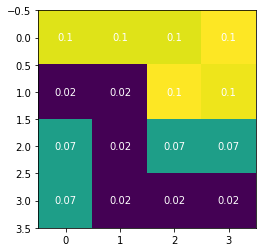

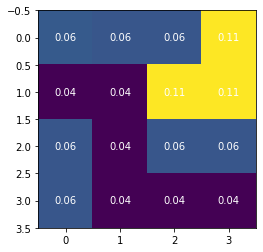

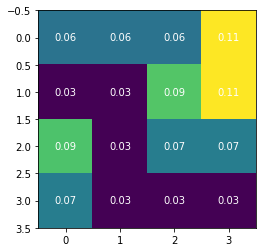

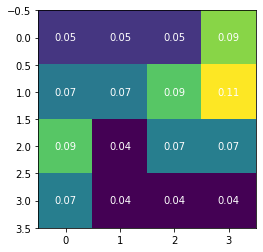

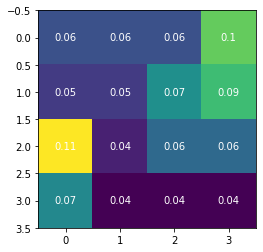

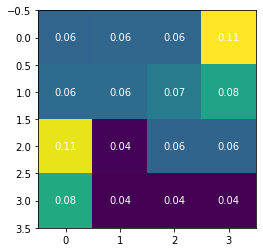

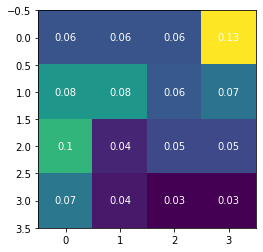

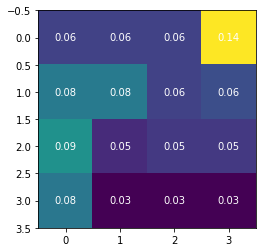

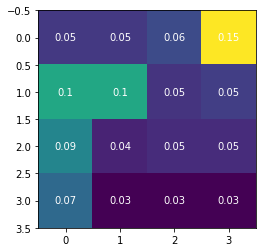

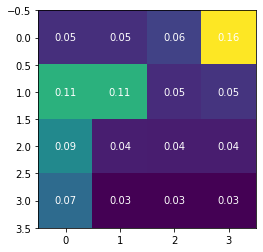

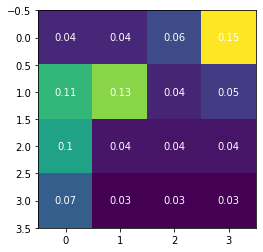

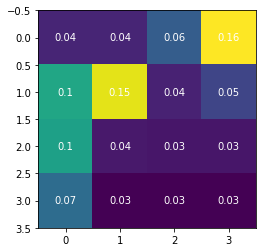

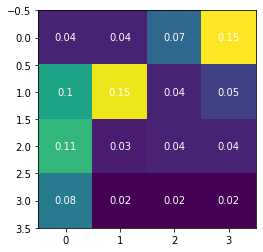

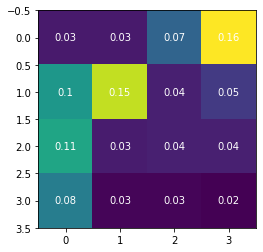

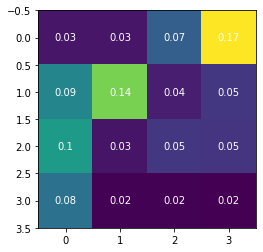

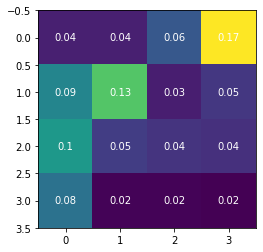

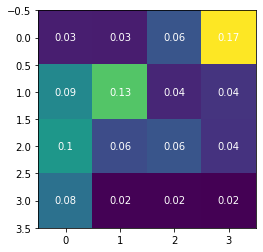

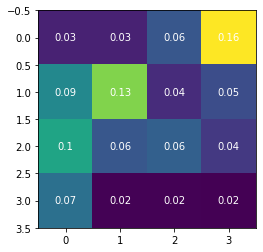

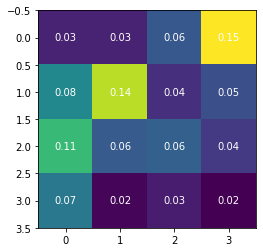

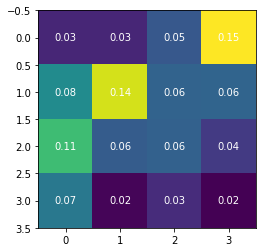

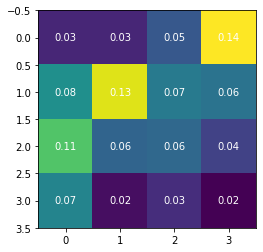

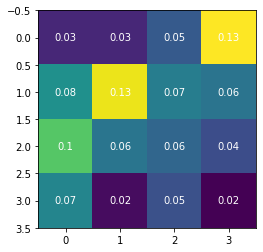

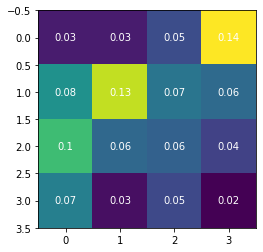

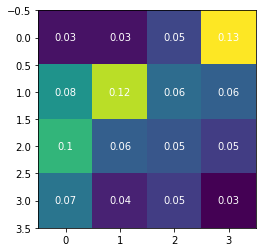

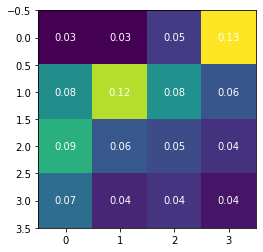

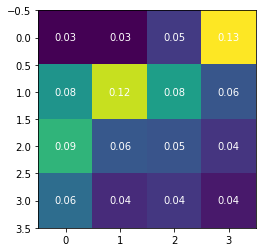

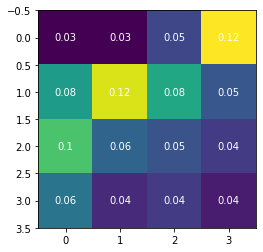

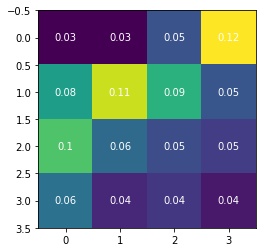

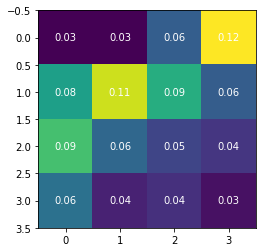

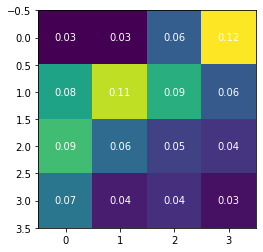

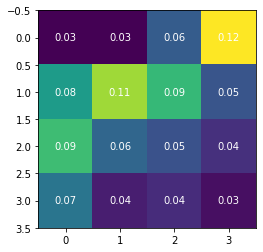

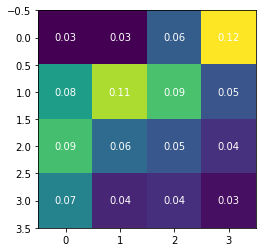

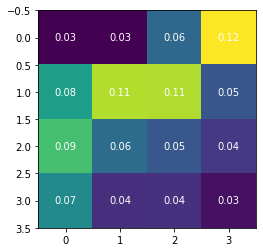

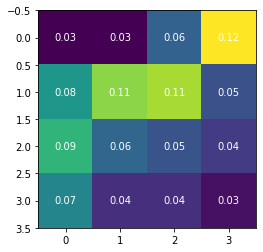

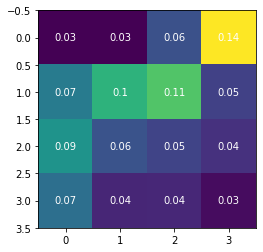

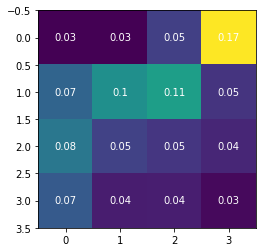

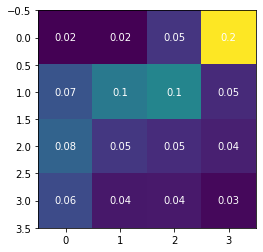

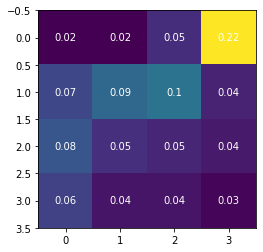

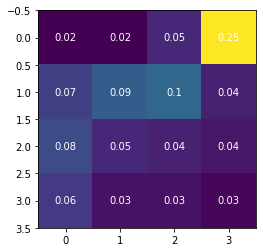

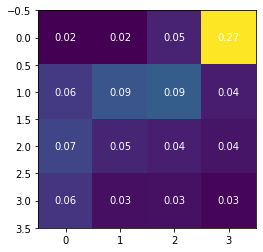

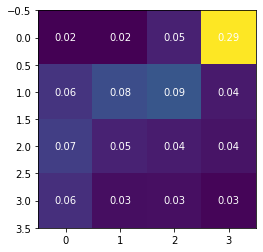

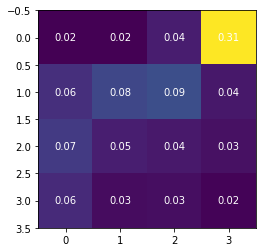

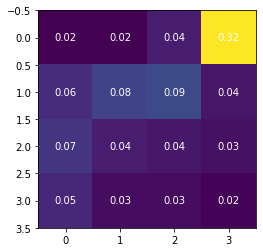

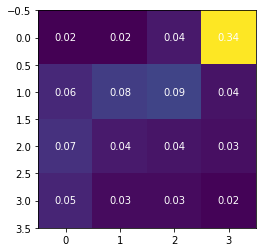

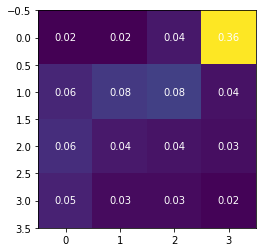

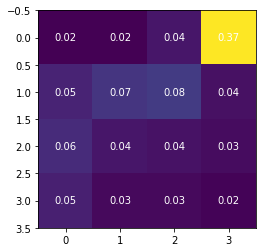

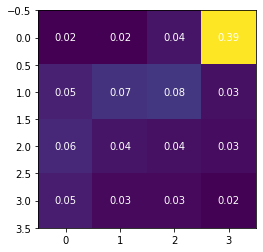

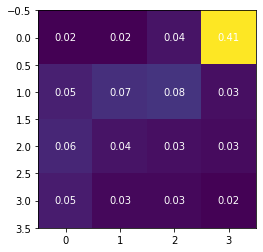

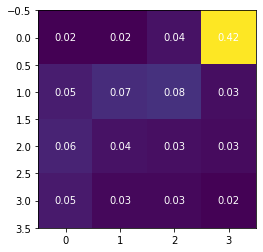

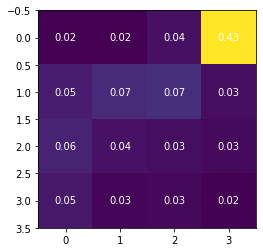

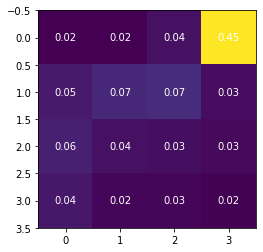

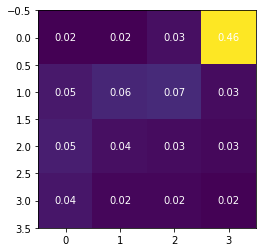

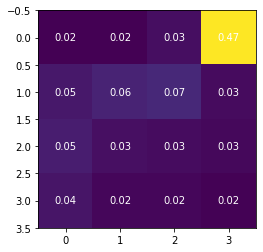

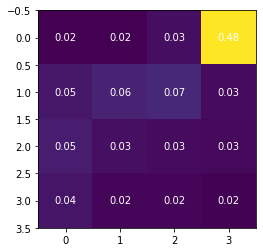

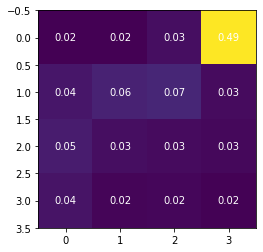

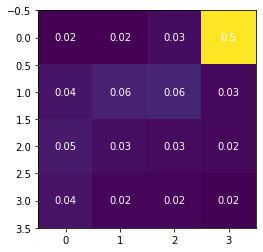

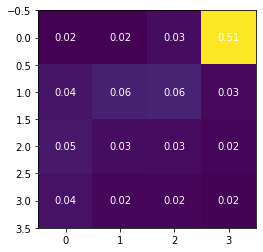

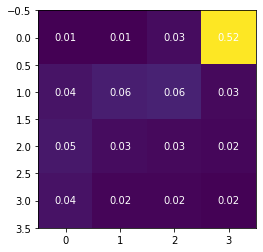

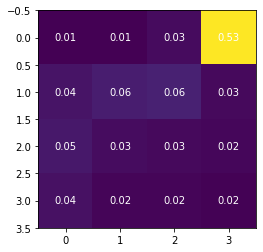

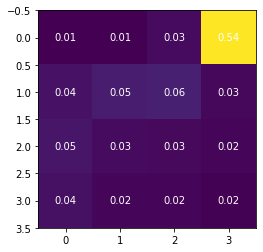

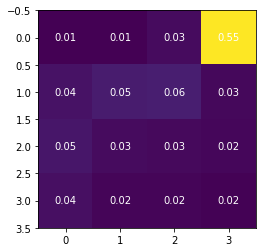

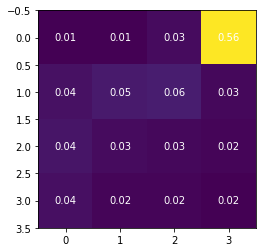

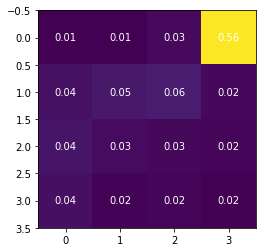

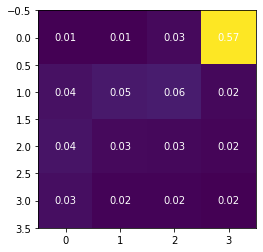

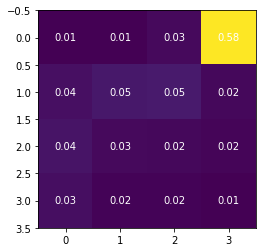

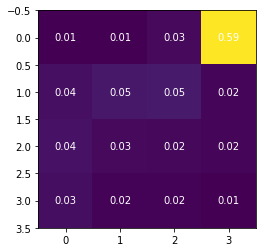

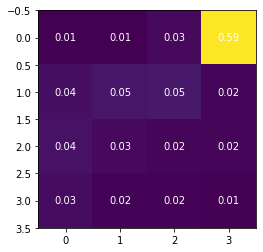

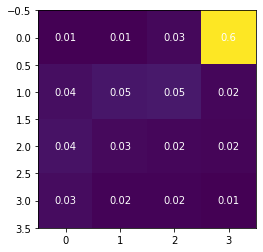

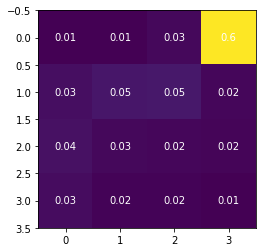

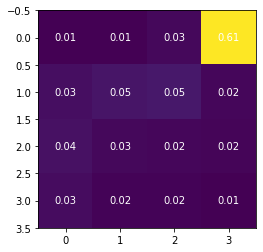

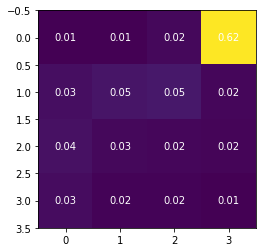

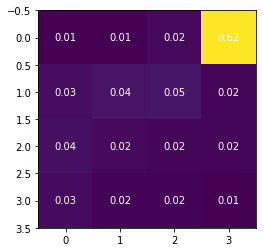

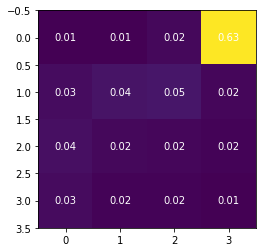

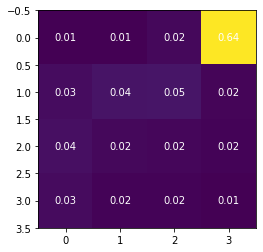

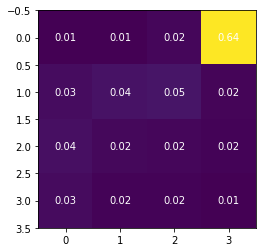

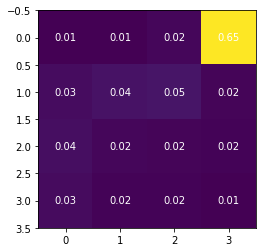

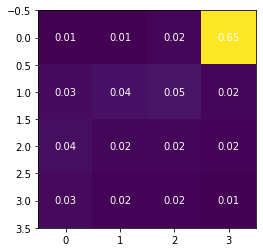

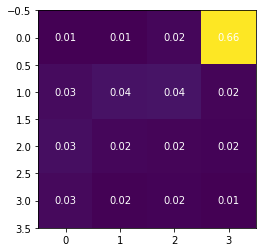

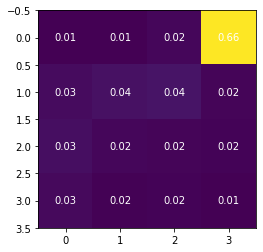

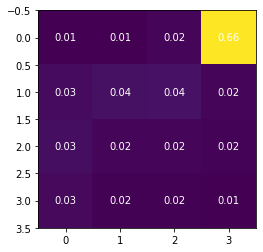

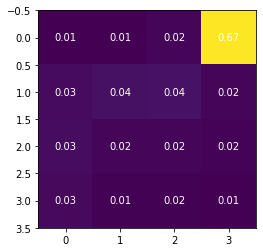

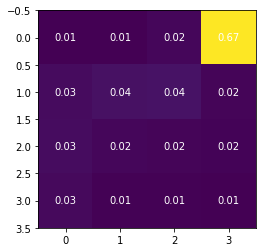

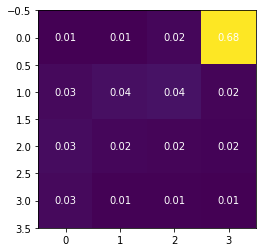

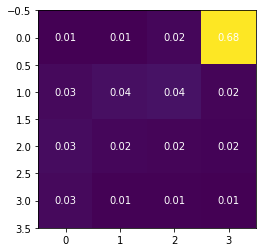

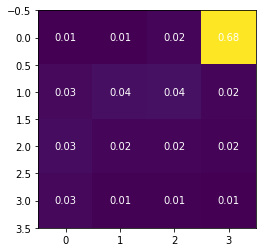

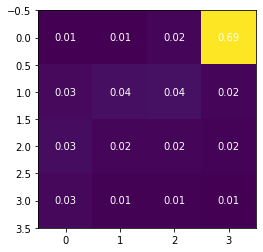

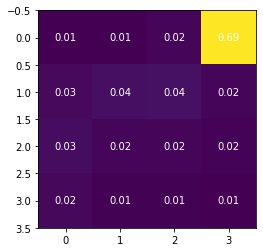

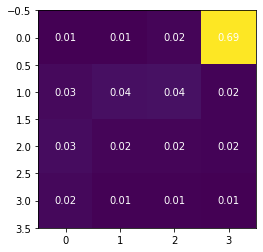

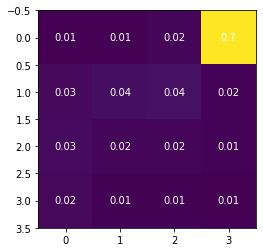

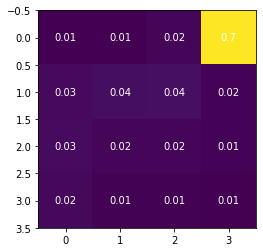

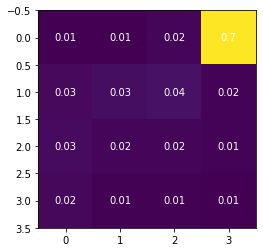

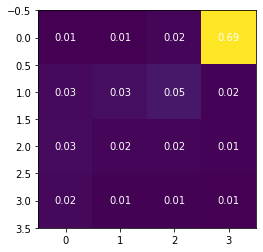

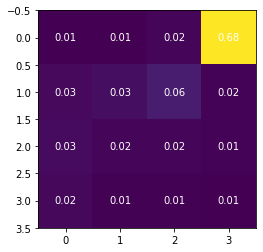

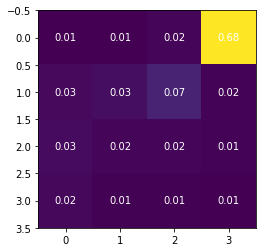

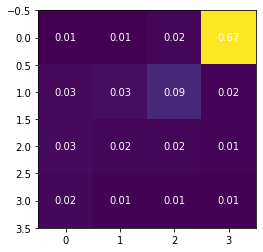

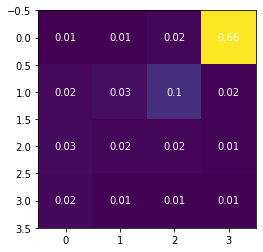

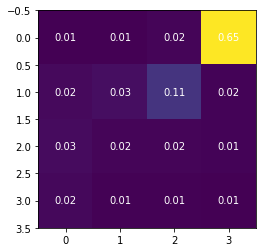

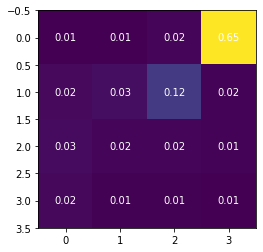

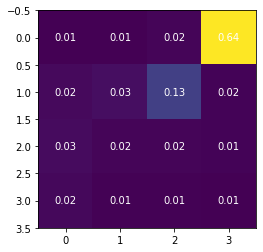

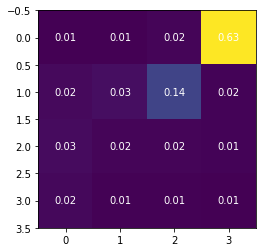

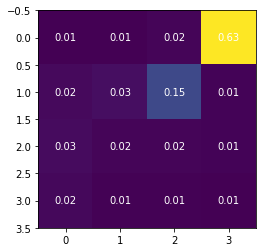

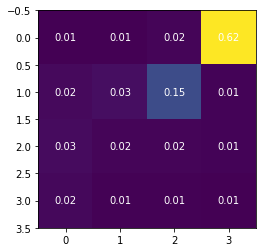

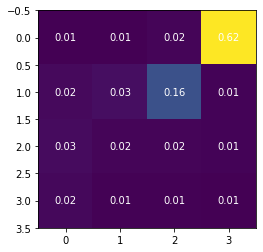

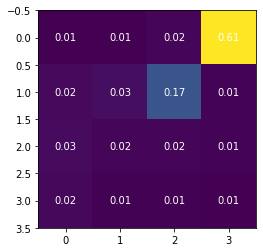

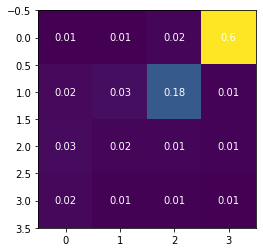

KeyboardInterrupt: ignored

In [93]:
# Search with trained net

# tree = Tree(net)
tree = MCTSAgent()
state = State()
while True:  
  distb = tree.think(state, 5000, temperature=1, show=True)
  pv_seq = tree.pv(state)
  print(pv_seq)
  state.play(pv_seq[0])
  # display_heatmap2(distb.reshape((BOARD_SIZE,BOARD_SIZE)))
  print(state)
  if state.terminal():
    break
  user_input = input("Input move: ")
  state.play(user_input)
  if state.terminal():
    break
print(state)
print(state.terminal_reward())